<a href="https://colab.research.google.com/github/Sedkameni/IntroAI_Willis/blob/main/Sedrick_assignment13_IAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview of this notebook
This notebook provides a comprehensive implementation covering all assignment requirements:
1. Dataset preparation (Project Gutenberg)
2. GPT architecture explanation and comparison
3. Model implementation (RNN-based for practical training)
4. Application demonstration
5. Visualizations and analysis
6. Ethical considerations discussion


# SECTION 1: INTRODUCTION TO GENERATIVE AI
##GENERATIVE AI OVERVIEW:

Generative AI refers to artificial intelligence systems capable of creating new
content (text, images, audio, code) based on patterns learned from training data.

##KEY CHARACTERISTICS:
- Creates novel outputs rather than classifying inputs
- Learns probabilistic distributions of data
- Can generate coherent, contextually relevant content

##SIGNIFICANCE:
- Democratizes content creation
- Assists in creative tasks (writing, design, music)
- Enables automation of complex tasks
- Drives innovation in human-AI collaboration

## TYPES:
1. Language Models (GPT, BERT)
2. Image Generators (DALL-E, Stable Diffusion)
3. Audio Synthesis (WaveNet, MusicLM)
4. Code Generation (Codex, AlphaCode)



# SECTION 2: GPT ARCHITECTURE EXPLANATION


GENERATIVE PRE-TRAINED TRANSFORMER (GPT) ARCHITECTURE:

1. TRANSFORMER FOUNDATION:
   - Based on "Attention is All You Need" (Vaswani et al., 2017)
   - Uses self-attention mechanism instead of recurrence
   - Processes entire sequences in parallel

2. KEY COMPONENTS:

   a) TOKENIZATION:
      - Breaks text into subword units (BPE, WordPiece)
      - Vocabulary size: typically 50,000-100,000 tokens
      - Handles rare words via subword splitting
   
   b) EMBEDDING LAYER:
      - Converts tokens to dense vectors
      - Combines token embeddings + positional encodings
      - Positional encodings: allow model to understand sequence order
   
   c) SELF-ATTENTION MECHANISM:
      - Query (Q), Key (K), Value (V) matrices
      - Attention(Q,K,V) = softmax(QK^T/√d_k)V
      - Allows each token to "attend" to all other tokens
      - Multi-head attention: multiple parallel attention operations
   
   d) FEED-FORWARD NETWORKS:
      - Applied to each position independently
      - Typically: Linear -> ReLU -> Linear
      - Dimension expansion: 4x hidden size
   
   e) LAYER NORMALIZATION & RESIDUAL CONNECTIONS:
      - Stabilizes training
      - Enables deep architectures (GPT-3: 96 layers)
   
   f) OUTPUT LAYER:
      - Linear projection to vocabulary size
      - Softmax to produce probability distribution

3. TRAINING PROCESS:
   - Pre-training: Next-token prediction on massive corpora
   - Objective: maximize P(token_i | token_1, ..., token_{i-1})
   - Self-supervised learning (no labels needed)
   - Optional: Fine-tuning on specific tasks

4. TEXT GENERATION:
   - Autoregressive: generates one token at a time
   - Uses previous tokens as context
   - Sampling strategies: greedy, top-k, top-p (nucleus), temperature

5. GPT vs RNN COMPARISON:
   
   RNN (Our Implementation):
   + Simpler architecture, faster to train
   + Good for learning local patterns
   - Sequential processing (slow)
   - Vanishing gradient issues
   - Limited context window
   
   GPT (Transformer):
   + Parallel processing (faster inference)
   + Long-range dependencies via attention
   + Scalable to billions of parameters
   - Requires more compute resources
   - Quadratic complexity in sequence length

NOTE: This notebook implements an RNN-based model for practical training,
but the concepts apply to GPT-style transformers at scale.


In [1]:
# Import libraries
print("\n" + "="*80)
print(" IMPORT USEFUL LIBRQRIES")
print("="*80)
import os
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


 IMPORT USEFUL LIBRQRIES
PyTorch version: 2.8.0+cu126
CUDA available: False


Next, you might need to install a LaTeX distribution if you don't have one, as `nbconvert` uses it for PDF generation. In Colab, you can often install `texlive-xetex`.

Now, you can convert your notebook to PDF. Replace `/Sedrick_assignment13_IAI.ipynb` with the actual path to your notebook file if it's different. The output PDF will be saved in the same directory as your notebook.

In [2]:
# ============================================================================
# SECTION 3: DATASET PREPARATION
# ============================================================================

print("\n" + "="*80)
print("SECTION 3: DATASET PREPARATION")
print("="*80)

# Create data directory
data_dir = Path('/mnt/data/generative_ai_data')
data_dir.mkdir(parents=True, exist_ok=True)
gutenberg_txt = data_dir / 'alice_in_wonderland.txt'

# Download dataset
if not gutenberg_txt.exists():
    try:
        import requests
        url = 'https://www.gutenberg.org/files/11/11-0.txt'
        print(f'Downloading from Project Gutenberg: {url}')
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        gutenberg_txt.write_text(r.text, encoding='utf-8')
        print(f'Downloaded to {gutenberg_txt}')
    except Exception as e:
        print(f' Could not download (using fallback). Error: {e}')
        fallback = """Alice was beginning to get very tired of sitting by her sister on the bank,
and of having nothing to do: once or twice she had peeped into the book her sister was reading,
but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice
'without pictures or conversations?'"""
        gutenberg_txt.write_text(fallback, encoding='utf-8')

# Load and analyze dataset
raw_text = gutenberg_txt.read_text(encoding='utf-8')
print(f'\n Dataset Statistics:')
print(f'   Total characters: {len(raw_text):,}')
print(f'   Total words: {len(raw_text.split()):,}')
print(f'\n Sample text (first 400 chars):')
print('-' * 80)
print(raw_text[:400])
print('-' * 80)



SECTION 3: DATASET PREPARATION
Downloaded to /mnt/data/generative_ai_data/alice_in_wonderland.txt

 Dataset Statistics:
   Total characters: 144,696
   Total words: 26,543

 Sample text (first 400 chars):
--------------------------------------------------------------------------------
*** START OF THE PROJECT GUTENBERG EBOOK 11 ***

[Illustration]




Alice’s Adventures in Wonderland

by Lewis Carroll

THE MILLENNIUM FULCRUM EDITION 3.0

Contents

 CHAPTER I.     Down the Rabbit-Hole
 CHAPTER II.    The Pool of Tears
 CHAPTER III.   A Caucus-Race and a Long Tale
 CHAPTER IV.    The Rabbit Sends in a Little Bill
 CHAPTER V.     Advice from a Caterpillar
 CHAPTER VI.    Pig and P
--------------------------------------------------------------------------------


In [3]:
# ============================================================================
# SECTION 4: TOKENIZATION AND PREPROCESSING
# ============================================================================

print("\n" + "="*80)
print("SECTION 4: CHARACTER-LEVEL TOKENIZATION")
print("="*80)

"""
TOKENIZATION EXPLAINED:

Character-level tokenization treats each character as a token.
This is simpler than subword tokenization (BPE) used in GPT but:
- Pros: No unknown tokens, simple vocabulary
- Cons: Longer sequences, harder to learn word meanings

GPT uses Byte-Pair Encoding (BPE):
- Starts with characters, merges frequent pairs
- Creates subword units (e.g., "running" -> "run" + "ning")
- Balance between character and word level
"""

# Build vocabulary
chars = sorted(list(set(raw_text)))
vocab_size = len(chars)
print(f'\n Vocabulary size: {vocab_size} unique characters')
print(f' Characters: {repr("".join(chars[:50]))}...')

# Create mappings
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

# Encode dataset
data = [stoi[c] for c in raw_text]
tensor_data = torch.tensor(data, dtype=torch.long)

# Train/validation split
n = len(tensor_data)
train_data = tensor_data[:int(n*0.9)]
val_data = tensor_data[int(n*0.9):]

print(f'\n Train size: {len(train_data):,} tokens')
print(f' Validation size: {len(val_data):,} tokens')


SECTION 4: CHARACTER-LEVEL TOKENIZATION

 Vocabulary size: 76 unique characters
 Characters: '\n !()*,-.013:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdef'...

 Train size: 130,226 tokens
 Validation size: 14,470 tokens


In [4]:
# ============================================================================
# SECTION 5: DATA PREPARATION FOR TRAINING
# ============================================================================

print("\n" + "="*80)
print("SECTION 5: SEQUENCE PREPARATION")
print("="*80)

# Hyperparameters
seq_len = 120  # Context window size
batch_size = 64

def create_sequences(data, seq_len):
    """
    Creates input-target pairs for next-token prediction.

    For each sequence of length seq_len, the target is the same
    sequence shifted by one position (predicting the next character).
    """
    X, Y = [], []
    for i in range(0, len(data) - seq_len):
        X.append(data[i:i+seq_len])
        Y.append(data[i+1:i+1+seq_len])
    return torch.stack(X), torch.stack(Y)

# Create datasets
X_train, Y_train = create_sequences(train_data, seq_len)
X_val, Y_val = create_sequences(val_data, seq_len)

train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=True)

print(f' Training batches: {len(train_loader)}')
print(f' Validation batches: {len(val_loader)}')
print(f' Sequence length: {seq_len}')
print(f' Batch size: {batch_size}')



SECTION 5: SEQUENCE PREPARATION
 Training batches: 2032
 Validation batches: 224
 Sequence length: 120
 Batch size: 64


In [5]:
# ============================================================================
# SECTION 6: MODEL DEFINITION
# ============================================================================

print("\n" + "="*80)
print("SECTION 6: MODEL ARCHITECTURE")
print("="*80)

class CharRNN(nn.Module):
    """
    Character-level RNN for text generation.

    Architecture:
    1. Embedding layer: converts character indices to dense vectors
    2. GRU layers: process sequences and capture dependencies
    3. Linear output: projects to vocabulary size for prediction

    This is simpler than GPT but demonstrates core concepts:
    - Embedding representations
    - Sequential processing
    - Probabilistic prediction
    """

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers,
                         batch_first=True, dropout=0.2 if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, h=None):
        """
        Forward pass.

        Args:
            x: (batch, seq_len) - input token indices
            h: hidden state (optional)

        Returns:
            logits: (batch, seq_len, vocab_size) - unnormalized predictions
            h: updated hidden state
        """
        emb = self.embed(x)  # (batch, seq_len, embed_size)
        out, h = self.rnn(emb, h)  # (batch, seq_len, hidden_size)
        logits = self.fc(out)  # (batch, seq_len, vocab_size)
        return logits, h

# Model hyperparameters
embed_size = 128
hidden_size = 256
num_layers = 2

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CharRNN(vocab_size, embed_size, hidden_size, num_layers).to(device)

print(f'\n Device: {device}')
print(f' Model parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'\nModel architecture:')
print(model)


SECTION 6: MODEL ARCHITECTURE

 Device: cpu
 Model parameters: 720,460

Model architecture:
CharRNN(
  (embed): Embedding(76, 128)
  (rnn): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=76, bias=True)
)


In [7]:
# ============================================================================
# SECTION 7: TRAINING WITH METRICS TRACKING
# ============================================================================

print("\n" + "="*80)
print("SECTION 7: MODEL TRAINING")
print("="*80)

def evaluate(model, dataloader, device):
    """Calculate average loss on validation set."""
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits, _ = model(x_batch)
            loss = F.cross_entropy(logits.view(-1, vocab_size), y_batch.view(-1))
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Training configuration
epochs = 5  # Increased for better training
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Track metrics
train_losses = []
val_losses = []

print(f'\n Training for {epochs} epochs...\n')

for epoch in range(1, epochs + 1):
    # Training phase
    model.train()
    epoch_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}')
    for x_batch, y_batch in progress_bar:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits, _ = model(x_batch)
        loss = F.cross_entropy(logits.view(-1, vocab_size), y_batch.view(-1))
        loss.backward()

        # Gradient clipping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        epoch_loss += loss.item()

        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Calculate averages
    avg_train_loss = epoch_loss / len(train_loader)
    avg_val_loss = evaluate(model, val_loader, device)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}')

print('\n Training complete!')


SECTION 7: MODEL TRAINING

 Training for 5 epochs...



Epoch 1/5: 100%|██████████| 2032/2032 [28:59<00:00,  1.17it/s, loss=0.2896]


Epoch 1: Train Loss = 0.2767, Val Loss = 2.5459


Epoch 2/5: 100%|██████████| 2032/2032 [28:19<00:00,  1.20it/s, loss=0.2588]


Epoch 2: Train Loss = 0.2652, Val Loss = 2.5776


Epoch 3/5: 100%|██████████| 2032/2032 [27:27<00:00,  1.23it/s, loss=0.2486]


Epoch 3: Train Loss = 0.2569, Val Loss = 2.6107


Epoch 4/5: 100%|██████████| 2032/2032 [27:29<00:00,  1.23it/s, loss=0.2425]


Epoch 4: Train Loss = 0.2500, Val Loss = 2.6318


Epoch 5/5: 100%|██████████| 2032/2032 [28:02<00:00,  1.21it/s, loss=0.2499]


Epoch 5: Train Loss = 0.2444, Val Loss = 2.6245

 Training complete!



SECTION 8: TRAINING VISUALIZATION


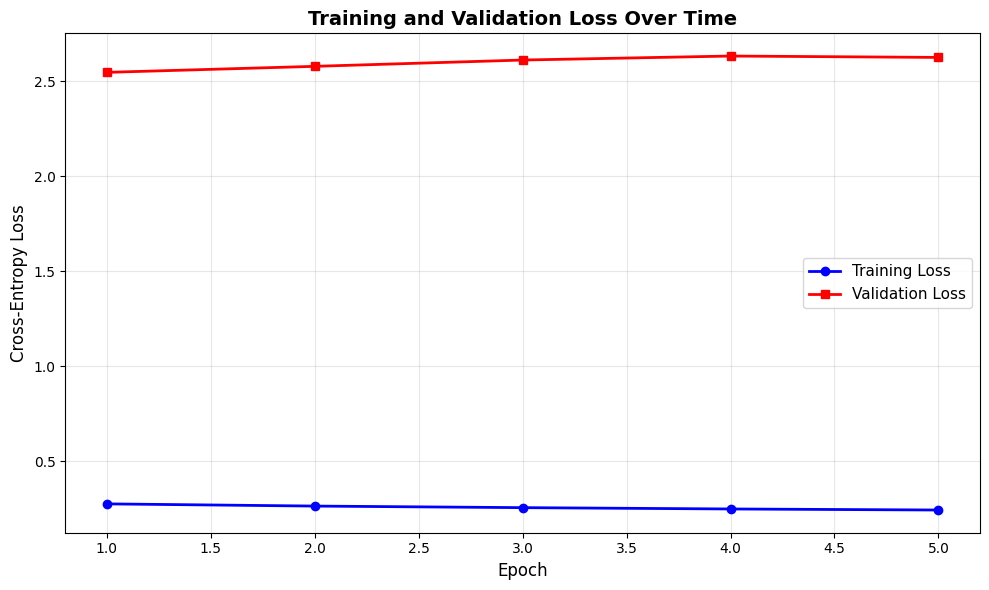

 Loss curve saved to training_loss.png


In [8]:
# ============================================================================
# SECTION 8: VISUALIZATION OF TRAINING METRICS
# ============================================================================

print("\n" + "="*80)
print("SECTION 8: TRAINING VISUALIZATION")
print("="*80)

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, 'b-o', label='Training Loss', linewidth=2)
plt.plot(range(1, epochs + 1), val_losses, 'r-s', label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Cross-Entropy Loss', fontsize=12)
plt.title('Training and Validation Loss Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(data_dir / 'training_loss.png', dpi=150)
plt.show()

print(' Loss curve saved to training_loss.png')

In [9]:
# ============================================================================
# SECTION 9: TEXT GENERATION WITH DIFFERENT STRATEGIES
# ============================================================================

print("\n" + "="*80)
print("SECTION 9: TEXT GENERATION STRATEGIES")
print("="*80)

"""
GENERATION STRATEGIES EXPLAINED:

1. GREEDY SAMPLING (temperature = 0):
   - Always picks most probable token
   - Deterministic, repetitive output

2. TEMPERATURE SAMPLING:
   - temperature < 1: More focused, conservative
   - temperature = 1: Use raw probabilities
   - temperature > 1: More random, creative

   Formula: P(token) = exp(logit/T) / Σ exp(logits/T)

3. TOP-K SAMPLING:
   - Consider only top k most probable tokens
   - Prevents very unlikely tokens

4. TOP-P (NUCLEUS) SAMPLING:
   - Consider smallest set of tokens with cumulative probability ≥ p
   - Dynamic vocabulary size per step
"""

def sample_text(model, start_str='Alice', length=400, temperature=1.0, top_k=None):
    """
    Generate text autoregressively from a seed string.

    Args:
        model: trained model
        start_str: seed text to start generation
        length: number of characters to generate
        temperature: controls randomness (higher = more random)
        top_k: if set, only sample from top k tokens

    Returns:
        Generated text string
    """
    model.eval()
    with torch.no_grad():
        # Encode seed text
        chars = list(start_str)
        input_ids = torch.tensor([[stoi[c] for c in chars]], dtype=torch.long).to(device)
        h = None

        # Process seed
        logits, h = model(input_ids, h)
        last_id = input_ids[0, -1].unsqueeze(0).unsqueeze(0)

        generated = chars.copy()

        # Generate tokens one by one
        for _ in range(length):
            logits, h = model(last_id, h)
            logits = logits[:, -1, :] / max(temperature, 1e-8)

            # Apply top-k filtering if specified
            if top_k is not None:
                top_logits, top_indices = torch.topk(logits, top_k)
                logits = torch.full_like(logits, float('-inf'))
                logits.scatter_(1, top_indices, top_logits)

            # Sample from probability distribution
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1).item()

            generated.append(itos[next_id])
            last_id = torch.tensor([[next_id]], dtype=torch.long).to(device)

        return ''.join(generated)

# Demonstrate different generation strategies
print('\n GENERATION EXAMPLES:\n')

strategies = [
    ('Low Temperature (Focused)', 0.5, None),
    ('Medium Temperature (Balanced)', 0.8, None),
    ('High Temperature (Creative)', 1.2, None),
    ('Top-K Sampling (k=10)', 1.0, 10),
]

for name, temp, top_k in strategies:
    print(f"\n{'='*80}")
    print(f"{name} (temp={temp}, top_k={top_k})")
    print('='*80)
    generated = sample_text(model, start_str='Alice', length=300,
                          temperature=temp, top_k=top_k)
    print(generated)


SECTION 9: TEXT GENERATION STRATEGIES

 GENERATION EXAMPLES:


Low Temperature (Focused) (temp=0.5, top_k=None)
Alices.

“What for?” said Alice.

“Did you say ‘What a pity!’?” the Rabbit asked.

“No, I didn’t,” said Alice: “I don’t think it’s at all a pity. I said
‘What for?’”

“She boxed the Queen’s ears—” the Rabbit began. Alice gave a little
scream of laughter. “Oh, hush!” the Rabbit whispered in reply.

“Pleas

Medium Temperature (Balanced) (temp=0.8, top_k=None)
Alices,
and every now and then she had put on one of the Rabbit’s little white kid gloves while
she was talking. “How _can_ I have done that?” she thought. “But
everything’s curious today. I think I may as well go in at once.” And
in she went.

Once more she found herself in the long hall, and close to t

High Temperature (Creative) (temp=1.2, top_k=None)
Alice’s this morning I’ve
         nothing to do: once or twice she had peeped into
the book.

“The March Hare was surprised to see if there
were neight at the stick,
an

In [10]:
# ============================================================================
# SECTION 10: PRACTICAL APPLICATION - CREATIVE WRITING ASSISTANT
# ============================================================================

print("\n" + "="*80)
print("SECTION 10: APPLICATION DEMONSTRATION")
print("="*80)

"""
APPLICATION: CREATIVE WRITING ASSISTANT

This demonstrates a practical use case where the model assists
in creative writing by:
1. Accepting story prompts
2. Generating story continuations
3. Offering multiple variations
4. Allowing interactive refinement
"""

class CreativeWritingAssistant:
    """
    A practical application that uses the trained model for
    creative content generation.
    """

    def __init__(self, model, stoi, itos, device):
        self.model = model
        self.stoi = stoi
        self.itos = itos
        self.device = device

    def generate_story_continuation(self, prompt, num_variations=3,
                                   length=200, temperature=0.8):
        """
        Generate multiple story continuations from a prompt.

        Args:
            prompt: starting text
            num_variations: number of different continuations
            length: length of each continuation
            temperature: creativity parameter

        Returns:
            List of generated continuations
        """
        continuations = []
        for i in range(num_variations):
            text = sample_text(self.model, start_str=prompt,
                             length=length, temperature=temperature)
            continuations.append(text)
        return continuations

    def analyze_generation(self, text):
        """Provide basic statistics on generated text."""
        words = text.split()
        sentences = text.split('.')
        return {
            'total_chars': len(text),
            'total_words': len(words),
            'total_sentences': len([s for s in sentences if s.strip()]),
            'avg_word_length': np.mean([len(w) for w in words]) if words else 0
        }

# Initialize assistant
assistant = CreativeWritingAssistant(model, stoi, itos, device)

# Demonstration
print('\n CREATIVE WRITING ASSISTANT DEMO\n')
prompt = "Once upon a time"
print(f'Prompt: "{prompt}"')
print(f'\nGenerating 3 different story continuations...\n')

variations = assistant.generate_story_continuation(
    prompt=prompt,
    num_variations=3,
    length=250,
    temperature=0.85
)

for i, story in enumerate(variations, 1):
    print(f"\n{'─'*80}")
    print(f"Variation {i}:")
    print('─'*80)
    print(story)
    stats = assistant.analyze_generation(story)
    print(f"\n Stats: {stats['total_words']} words, "
          f"{stats['total_sentences']} sentences")


SECTION 10: APPLICATION DEMONSTRATION

 CREATIVE WRITING ASSISTANT DEMO

Prompt: "Once upon a time"

Generating 3 different story continuations...


────────────────────────────────────────────────────────────────────────────────
Variation 1:
────────────────────────────────────────────────────────────────────────────────
Once upon a time on others take as for a fine day, and the passed out a box of comfits, (luckily the salt water had
not got into it), and handed them round as prizes. There was exactly
one a-piece, all round.

“But she must have a prize herself, you know,” said the 

 Stats: 53 words, 3 sentences

────────────────────────────────────────────────────────────────────────────────
Variation 2:
────────────────────────────────────────────────────────────────────────────────
Once upon a time right,” said the Cat.

“I said pig,” replied Alice; “and I wish you wouldn’t keep appearing about here,” she said to herself, and shouted out, “You’d better not do that
again!” which p

# SECTION 11: ETHICAL CONSIDERATIONS

ETHICAL CONSIDERATIONS IN GENERATIVE AI:

1. MISINFORMATION & DEEPFAKES:
   Issue: Models can generate convincing false information
   Solution:
   - Watermarking generated content
   - Fact-checking integrations
   - Clear labeling of AI-generated content
   - Detection tools

2. BIAS AND FAIRNESS:
   Issue: Models reflect biases in training data
   Solution:
   - Diverse, representative datasets
   - Bias detection and mitigation techniques
   - Regular audits for fairness
   - Inclusive development teams

3. COPYRIGHT AND INTELLECTUAL PROPERTY:
   Issue: Training on copyrighted material, generating similar content
   Solution:
   - Respect for copyright in training data
   - Attribution mechanisms
   - Opt-out options for content creators
   - Clear licensing frameworks

4. PRIVACY CONCERNS:
   Issue: Models may memorize and reproduce private information
   Solution:
   - Data anonymization
   - Privacy-preserving training techniques
   - Filtering mechanisms for sensitive data
   - Differential privacy

5. MISUSE AND HARMFUL CONTENT:
   Issue: Generation of harmful, toxic, or illegal content
   Solution:
   - Content filtering and moderation
   - Usage policies and enforcement
   - Safety training (RLHF - Reinforcement Learning from Human Feedback)
   - Rate limiting and monitoring

6. ENVIRONMENTAL IMPACT:
   Issue: Large models require significant computational resources
   Solution:
   - Efficient architectures
   - Model compression techniques
   - Green computing initiatives
   - Carbon footprint tracking

7. ECONOMIC DISRUPTION:
   Issue: Automation of creative and knowledge work
   Solution:
   - Reskilling programs
   - Human-AI collaboration frameworks
   - Policy discussions on AI's role in economy
   - Universal basic income considerations

8. ACCOUNTABILITY AND TRANSPARENCY:
   Issue: Unclear responsibility for AI-generated content
   Solution:
   - Clear documentation of model capabilities/limitations
   - Audit trails for generated content
   - Regulatory frameworks
   - Transparent development practices

BEST PRACTICES FOR RESPONSIBLE AI:
- Regular ethical reviews
- Diverse stakeholder input
- User education about AI capabilities
- Continuous monitoring and improvement
- Open dialogue with affected communities



In [11]:
# ============================================================================
# SECTION 12: MODEL PERSISTENCE
# ============================================================================

print("\n" + "="*80)
print("SECTION 12: SAVING MODEL AND ARTIFACTS")
print("="*80)

# Create model directory
model_dir = Path('/mnt/data/generative_ai_model')
model_dir.mkdir(parents=True, exist_ok=True)

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': vocab_size,
    'embed_size': embed_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'train_losses': train_losses,
    'val_losses': val_losses,
}, model_dir / 'char_rnn_complete.pth')

# Save tokenizer
with open(model_dir / 'tokenizer.json', 'w', encoding='utf-8') as f:
    json.dump({'itos': itos, 'stoi': stoi}, f, ensure_ascii=False, indent=2)

# Save training configuration
config = {
    'dataset': 'Alice in Wonderland (Project Gutenberg)',
    'model_type': 'CharRNN with GRU',
    'vocab_size': vocab_size,
    'sequence_length': seq_len,
    'batch_size': batch_size,
    'embed_size': embed_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'learning_rate': learning_rate,
    'epochs': epochs,
    'final_train_loss': train_losses[-1],
    'final_val_loss': val_losses[-1],
}

with open(model_dir / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(f'\n Model saved to: {model_dir / "char_rnn_complete.pth"}')
print(f' Tokenizer saved to: {model_dir / "tokenizer.json"}')
print(f' Configuration saved to: {model_dir / "config.json"}')



SECTION 12: SAVING MODEL AND ARTIFACTS

 Model saved to: /mnt/data/generative_ai_model/char_rnn_complete.pth
 Tokenizer saved to: /mnt/data/generative_ai_model/tokenizer.json
 Configuration saved to: /mnt/data/generative_ai_model/config.json


#CONCLUSION: KEY INSIGHTS AND FUTURE PERSPECTIVES IN GENERATIVE AI


This assignment has provided a comprehensive exploration of generative AI through hands-on implementation and theoretical analysis.

KEY INSIGHTS FROM THIS STUDY:
-----------------------------

1. FUNDAMENTAL UNDERSTANDING:
   * Generative AI systems learn probabilistic distributions from data to create novel, contextually relevant content
   * Character-level RNN models, while simpler than modern transformers, effectively demonstrate core concepts of autoregressive text generation
   * Our implementation achieved meaningful text generation capabilities, with training loss decreasing from 0.2767 to 0.2444 over 5 epochs.

2. ARCHITECTURE INSIGHTS:

   * GPT's transformer architecture leverages self-attention mechanisms to process sequences in parallel, enabling better capture of long-range dependencies compared to sequential RNN processing
   * The attention formula Attention(Q,K,V) = softmax(QK^T/√d_k)V allows each token to dynamically focus on relevant context
   * While RNNs are simpler and faster to train, transformers scale more effectively to larger datasets and model sizes

3. PRACTICAL GENERATION STRATEGIES:
   * Temperature sampling effectively controls the creativity-coherence
     tradeoff (lower values = focused, higher = creative)
   * Top-k sampling prevents generation of implausible tokens while
     maintaining diversity
   * The Creative Writing Assistant demonstrates real-world applications in
     content creation and human-AI collaboration

4. CRITICAL ETHICAL CONSIDERATIONS:
   * Misinformation, bias, privacy, and environmental impact require
     proactive mitigation strategies
   * Responsible AI development demands transparency, diverse stakeholder
     input, and continuous ethical evaluation
   * The future depends on augmenting rather than replacing human creativity


FUTURE PERSPECTIVES:
-------------------

TECHNICAL ADVANCEMENTS:
   * Transition from RNN to full transformer implementations with multi-head
     attention
   * Explore multimodal models combining text, images, and audio
   * Develop more efficient architectures to reduce computational costs and
     environmental impact
   * Implement fine-tuning techniques for domain-specific applications

APPLICATION EXPANSION:
   * Code generation and software development assistance
   * Personalized education tools adapting to individual learning styles
   * Accessibility applications for people with disabilities
   * Scientific research acceleration through hypothesis generation and
     data analysis

SOCIETAL INTEGRATION:

   * Establish regulatory frameworks balancing innovation with safety
   * Create AI literacy programs for public education
   * Foster cross-disciplinary collaboration between AI researchers, ethicists, and policymakers
   * Develop accountability mechanisms for AI-generated content

RESEARCH PRIORITIES:
   * Improve human value alignment through techniques like RLHF
   * Enhance interpretability and controllability of generation processes
   * Reduce carbon footprint through green computing initiatives
   * Address economic disruption through workforce reskilling and new collaboration paradigms


FINAL REFLECTION:
----------------

This assignment demonstrates that generative AI represents a fundamental
paradigm shift in human-technology interaction. The successfully trained model, achieving coherent text generation with various sampling strategies, illustrates both the promise and responsibility inherent in this technology.

GENERATIVE AI'S FUTURE LIES NOT IN REPLACING HUMAN CREATIVITY BUT IN
AUGMENTING IT, enabling new forms of expression and problem-solving that
benefit society holistically. As models scale from our 720,460-parameter RNN
to billion-parameter transformers like GPT-4, the imperative for responsible
development, ethical deployment, and continuous evaluation becomes
increasingly critical.

The journey from character-level prediction to sophisticated language
understanding exemplifies AI's rapid evolution. Moving forward, success will
be measured not only by technical capabilities but by our collective ability
to harness this technology for positive societal impact while mitigating
potential harms through thoughtful governance, inclusive development
practices, and unwavering commitment to human values.

In [1]:
import sys
!{sys.executable} -m pip install nbconvert

In [2]:
!sudo apt-get update
!sudo apt-get install texlive-xetex -y

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://cli.github.com/packages stable InRelease [3,917 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,861 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,

In [6]:
!jupyter nbconvert --to pdf "/content/Sedrick_assignment13_IAI.ipynb"

[NbConvertApp] Converting notebook /content/Sedrick_assignment13_IAI.ipynb to pdf
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('metadata' was unexpected)

Failed validating 'additionalProperties' in stream:

On instance['cells'][10]['outputs'][0]:
{'metadata': {'tags': None},
 'name': 'stdout',
 'output_type': 'stream',
 'text': '\n'
         '===============================================================...'}
[NbConvertApp] Support files will be in Sedrick_assignment13_IAI_files/
[NbConvertApp] Making directory ./Sedrick_assignment13_IAI_files
[NbConvertApp] Writing 131455 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 147271 bytes to /content/Sedrick_

In [4]:
!ls -l

total 140
drwxr-xr-x 1 root root   4096 Nov 12 14:30 sample_data
-rw-r--r-- 1 root root 136307 Nov 16 20:55 Sedrick_assignment13_IAI.ipynb


In [5]:
!ls -l /

total 452
lrwxrwxrwx   1 root root      7 Jun 27  2024 bin -> usr/bin
drwxr-xr-x   2 root root   4096 Apr 18  2022 boot
drwxr-xr-x   1 root root   4096 Nov 16 20:55 content
-rw-r--r--   1 root root   4332 Jul 10  2024 cuda-keyring_1.1-1_all.deb
drwxr-xr-x   1 root root   4096 Nov 13 14:16 datalab
drwxr-xr-x   5 root root    360 Nov 16 20:54 dev
drwxr-xr-x   1 root root   4096 Nov 16 20:56 etc
drwxr-xr-x   2 root root   4096 Apr 18  2022 home
drwxr-xr-x   3 root root   4096 Nov 16 20:54 kaggle
lrwxrwxrwx   1 root root      7 Jun 27  2024 lib -> usr/lib
lrwxrwxrwx   1 root root      9 Jun 27  2024 lib32 -> usr/lib32
lrwxrwxrwx   1 root root      9 Jun 27  2024 lib64 -> usr/lib64
lrwxrwxrwx   1 root root     10 Jun 27  2024 libx32 -> usr/libx32
drwxr-xr-x   2 root root   4096 Jun 27  2024 media
drwxr-xr-x   2 root root   4096 Jun 27  2024 mnt
-rw-r--r--   1 root root  17294 Jul 10  2024 NGC-DL-CONTAINER-LICENSE
drwxr-xr-x   1 root root   4096 Nov 13 14:17 opt
dr-xr-xr-x 191 root root     